In [1]:
import netCDF4 as nc
import datetime as dt
import subprocess
import requests
import matplotlib.pyplot as plt
import cmocean
import numpy as np
import os
import glob
import dateutil as dutil
from salishsea_tools import viz_tools
%matplotlib inline

In [2]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as fm:
    tmask=np.copy(fm.variables['tmask'])
    umask=np.copy(fm.variables['umask'])
    vmask=np.copy(fm.variables['vmask'])
    navlon=np.copy(fm.variables['nav_lon'])
    navlat=np.copy(fm.variables['nav_lat'])
    e3t_0=np.copy(fm.variables['e3t_0'])
    e3u_0=np.copy(fm.variables['e3u_0'])
    e3v_0=np.copy(fm.variables['e3v_0'])
    e1t=np.copy(fm.variables['e1t'])
    e2t=np.copy(fm.variables['e2t'])
    e1v=np.copy(fm.variables['e1v'])
    e2u=np.copy(fm.variables['e2u'])
    A=fm.variables['e1t'][0,:,:]*fm.variables['e2t'][0,:,:]*tmask[0,0,:,:]

In [3]:
t0=dt.datetime(2016,1,6) # 1st start date of run
#t0=dt.datetime(2015,1,11) # 1st start date of run
#te=dt.datetime(2016,12,1)# last start date of runfnum=18
stm=np.shape(tmask)
SiN=2.0
#nlen=36
nlen=20
dlist=[t0+dt.timedelta(days=ii*10) for ii in range(0,nlen)]

In [4]:
#sdir0='/results/SalishSea/nowcast-green/'
#sdir1='/results/SalishSea/hindcast/'
#sdir1='/data/eolson/MEOPAR/SS36runs/CedarRuns/spring2015_Z2/'
#sdir1='/data/eolson/MEOPAR/SS36runs/CedarRuns/spring2015_eff0/'
#sdir1='/data/eolson/MEOPAR/SS36runs/CedarRuns/spring2015_NoMZME/'
#sdir1='/data/eolson/MEOPAR/SS36runs/CedarRuns/spring15spun_Ztest/'
sdir1='/data/eolson/MEOPAR/SS36runs/CedarRuns/spring16spun_Z7/'
tit=[i for i in sdir1.split('/') if len(i)>0][-1]
tit

'spring16spun_Z7'

In [5]:
tmaskC=np.copy(tmask)
tmaskC[:,:,370:490,:12]=0
tmaskC[:,:,887:,30:70]=0

In [6]:
tlist=dlist
SiGlobalTot=dict()
SiTot=dict()
BSiTot=dict()
DiatTot=dict()
changeSiGlobalTot=dict()
for idir in (sdir1,):
    fformat1='%d%b%y/'
    if idir.startswith('/data/eolson/MEOPAR/SS36runs/'):
        fformatT='SalishSea_1h_*_ptrc_T_%Y%m%d-*[0-9].nc'
        fformatP='SalishSea_1h_*_ptrc_T_%Y%m%d-*[0-9].nc'
    #elif idir==sdir0:
    #    fformatT='SalishSea_1h_%Y%m%d_%Y%m%d_ptrc_T.nc'
    #    fformatP='SalishSea_1h_%Y%m%d_%Y%m%d_grid_T.nc'
    elif idir==sdir1:
        fformatT='SalishSea_1h_%Y%m%d_%Y%m%d_ptrc_T.nc'
        fformatP='SalishSea_1h_%Y%m%d_%Y%m%d_carp_T.nc'
    sumSi=np.zeros((len(tlist),stm[2],stm[3]))
    sumBSi=np.zeros((len(tlist),stm[2],stm[3]))
    sumDiat=np.zeros((len(tlist),stm[2],stm[3]))
    ind=-1
    for idt0 in tlist:
        ind=ind+1
        cdir=idt0.strftime(fformat1).lower()
        iffT=idt0.strftime(fformatT)
        iffP=idt0.strftime(fformatP)
        if idir.startswith('/data/eolson/MEOPAR/SS36runs/'):
            sffT=idir+iffT
            sffP=idir+iffP
        elif idir.startswith('/results/'):
            sffT=idir+cdir+iffT
            sffP=idir+cdir+iffP
        f=nc.Dataset(glob.glob(sffT)[0])
        print(sffT)
        fP=nc.Dataset(glob.glob(sffP)[0])
        #if idir==sdir0:
        #    e3t=np.expand_dims((1+fP.variables['sossheig'][0,:,:]/np.sum(e3t_0*tmask,1)),0)*e3t_0
        if idir==sdir1:
            e3t=fP.variables['e3t'][:2,:,:,:]
        Vol=A*e3t
        sumSi[ind,:,:]=1e-3*np.sum(tmaskC[0,:,:,:]*Vol[0,:,:,:]*f.variables['silicon'][0,:,:,:],0) #mmol/m3*m3*10^-3=mol
        sumBSi[ind,:,:]=1e-3*np.sum(tmaskC[0,:,:,:]*Vol[0,:,:,:]*f.variables['biogenic_silicon'][0,:,:,:],0) #mmol/m3*m3*10^-3=mol
        sumDiat[ind,:,:]=SiN*1e-3*np.sum(tmaskC[0,:,:,:]*Vol[0,:,:,:]*f.variables['diatoms'][0,:,:,:],0) #mmol/m3*m3*10^-3=mol
        f.close()
        fP.close()
    SiGlobalTot[idir]=np.sum(np.sum(sumSi+sumBSi+sumDiat,2),1)
    SiTot[idir]=np.sum(np.sum(sumSi,2),1)
    BSiTot[idir]=np.sum(np.sum(sumBSi,2),1)
    DiatTot[idir]=np.sum(np.sum(sumDiat,2),1)
    changeSiGlobalTot[idir]=[SiGlobalTot[idir][ii+1]-SiGlobalTot[idir][ii] for ii in range(0,len(tlist)-1)]

/data/eolson/MEOPAR/SS36runs/CedarRuns/spring16spun_Z7/SalishSea_1h_*_ptrc_T_20160106-*[0-9].nc
/data/eolson/MEOPAR/SS36runs/CedarRuns/spring16spun_Z7/SalishSea_1h_*_ptrc_T_20160116-*[0-9].nc
/data/eolson/MEOPAR/SS36runs/CedarRuns/spring16spun_Z7/SalishSea_1h_*_ptrc_T_20160126-*[0-9].nc
/data/eolson/MEOPAR/SS36runs/CedarRuns/spring16spun_Z7/SalishSea_1h_*_ptrc_T_20160205-*[0-9].nc
/data/eolson/MEOPAR/SS36runs/CedarRuns/spring16spun_Z7/SalishSea_1h_*_ptrc_T_20160215-*[0-9].nc
/data/eolson/MEOPAR/SS36runs/CedarRuns/spring16spun_Z7/SalishSea_1h_*_ptrc_T_20160225-*[0-9].nc
/data/eolson/MEOPAR/SS36runs/CedarRuns/spring16spun_Z7/SalishSea_1h_*_ptrc_T_20160306-*[0-9].nc
/data/eolson/MEOPAR/SS36runs/CedarRuns/spring16spun_Z7/SalishSea_1h_*_ptrc_T_20160316-*[0-9].nc
/data/eolson/MEOPAR/SS36runs/CedarRuns/spring16spun_Z7/SalishSea_1h_*_ptrc_T_20160326-*[0-9].nc
/data/eolson/MEOPAR/SS36runs/CedarRuns/spring16spun_Z7/SalishSea_1h_*_ptrc_T_20160405-*[0-9].nc
/data/eolson/MEOPAR/SS36runs/CedarRuns/s

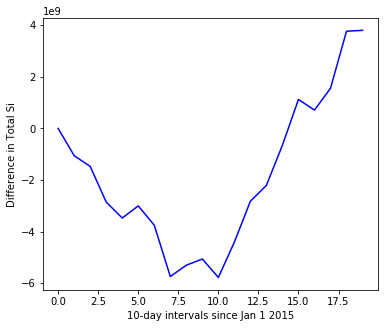

In [7]:
fig,ax=plt.subplots(1,1,figsize=(6,5))
ax.plot(SiGlobalTot[sdir1]-SiGlobalTot[sdir1][0],'b-')
ax.set_xlabel('10-day intervals since Jan 1 2015')
ax.set_ylabel('Difference in Total Si')

In [8]:
# copy restart and add 7 to Si old and new

## repeat for N

In [9]:
tlist=dlist
NGlobalTot=dict()
VolTot=dict()
NO3Tot=dict()
NH4Tot=dict()
PONTot=dict()
DONTot=dict()
DiatTot=dict()
MyriTot=dict()
NanoTot=dict()
MiZoTot=dict()
changeNGlobalTot=dict()
for idir in (sdir1,):
    fformat1='%d%b%y/'
    if idir.startswith('/data/eolson/MEOPAR/SS36runs/CedarRuns/'):
        fformatT='SalishSea_1h_*_ptrc_T_%Y%m%d-*[0-9].nc'
        fformatP='SalishSea_1h_*_ptrc_T_%Y%m%d-*[0-9].nc'
    #elif idir==sdir0:
    #    fformatT='SalishSea_1h_%Y%m%d_%Y%m%d_ptrc_T.nc'
    #    fformatP='SalishSea_1h_%Y%m%d_%Y%m%d_grid_T.nc'
    elif idir==sdir1:
        fformatT='SalishSea_1h_%Y%m%d_%Y%m%d_ptrc_T.nc'
        fformatP='SalishSea_1h_%Y%m%d_%Y%m%d_carp_T.nc'
    sumNO3=np.zeros((len(tlist),stm[2],stm[3]))
    sumVol=np.zeros((len(tlist),stm[2],stm[3]))
    sumNH4=np.zeros((len(tlist),stm[2],stm[3]))
    sumPON=np.zeros((len(tlist),stm[2],stm[3]))
    sumDON=np.zeros((len(tlist),stm[2],stm[3]))
    sumDiat=np.zeros((len(tlist),stm[2],stm[3]))
    sumMyri=np.zeros((len(tlist),stm[2],stm[3]))
    sumNano=np.zeros((len(tlist),stm[2],stm[3]))
    sumMiZo=np.zeros((len(tlist),stm[2],stm[3]))
    ind=-1
    for idt0 in tlist:
        ind=ind+1
        cdir=idt0.strftime(fformat1).lower()
        iffT=idt0.strftime(fformatT)
        iffP=idt0.strftime(fformatP)
        if idir.startswith('/data/eolson/MEOPAR/SS36runs/CedarRuns/'):
            sffT=idir+iffT
            sffP=idir+iffP
        elif idir.startswith('/results/'):
            sffT=idir+cdir+iffT
            sffP=idir+cdir+iffP
        f=nc.Dataset(glob.glob(sffT)[0])
        print(sffT)
        fP=nc.Dataset(glob.glob(sffP)[0])
        #if idir==sdir0:
        #    e3t=np.expand_dims((1+fP.variables['sossheig'][0,:,:]/np.sum(e3t_0*tmask,1)),0)*e3t_0
        if idir==sdir1:
            e3t=fP.variables['e3t'][:2,:,:,:]
        Vol=A*e3t
        sumVol[ind,:,:]=1e-3*np.sum(tmaskC[0,:,:,:]*Vol[0,:,:,:],0) #mmol/m3*m3*10^-3=mol
        sumNO3[ind,:,:]=1e-3*np.sum(tmaskC[0,:,:,:]*Vol[0,:,:,:]*f.variables['nitrate'][0,:,:,:],0) #mmol/m3*m3*10^-3=mol
        sumNH4[ind,:,:]=1e-3*np.sum(tmaskC[0,:,:,:]*Vol[0,:,:,:]*f.variables['ammonium'][0,:,:,:],0) #mmol/m3*m3*10^-3=mol
        sumPON[ind,:,:]=1e-3*np.sum(tmaskC[0,:,:,:]*Vol[0,:,:,:]*f.variables['particulate_organic_nitrogen'][0,:,:,:],0) #mmol/m3*m3*10^-3=mol
        sumDON[ind,:,:]=1e-3*np.sum(tmaskC[0,:,:,:]*Vol[0,:,:,:]*f.variables['dissolved_organic_nitrogen'][0,:,:,:],0) #mmol/m3*m3*10^-3=mol
        sumDiat[ind,:,:]=1e-3*np.sum(tmaskC[0,:,:,:]*Vol[0,:,:,:]*f.variables['diatoms'][0,:,:,:],0) #mmol/m3*m3*10^-3=mol
        sumMyri[ind,:,:]=1e-3*np.sum(tmaskC[0,:,:,:]*Vol[0,:,:,:]*f.variables['ciliates'][0,:,:,:],0) #mmol/m3*m3*10^-3=mol
        sumMiZo[ind,:,:]=1e-3*np.sum(tmaskC[0,:,:,:]*Vol[0,:,:,:]*f.variables['microzooplankton'][0,:,:,:],0) #mmol/m3*m3*10^-3=mol
        f.close()
        fP.close()
    NGlobalTot[idir]=np.sum(np.sum(sumNO3+sumNH4+sumPON+sumDON+sumDiat+sumMyri+sumNano+sumMiZo,2),1)
    VolTot[idir]=np.sum(np.sum(sumVol,2),1)
    NO3Tot[idir]=np.sum(np.sum(sumNO3,2),1)
    NH4Tot[idir]=np.sum(np.sum(sumNH4,2),1)
    PONTot[idir]=np.sum(np.sum(sumPON,2),1)
    DONTot[idir]=np.sum(np.sum(sumDON,2),1)
    DiatTot[idir]=np.sum(np.sum(sumDiat,2),1)
    MyriTot[idir]=np.sum(np.sum(sumMyri,2),1)
    NanoTot[idir]=np.sum(np.sum(sumNano,2),1)
    MiZoTot[idir]=np.sum(np.sum(sumMiZo,2),1)
    changeNGlobalTot[idir]=[NGlobalTot[idir][ii+1]-NGlobalTot[idir][ii] for ii in range(0,len(tlist)-1)]

/data/eolson/MEOPAR/SS36runs/CedarRuns/spring16spun_Z7/SalishSea_1h_*_ptrc_T_20160106-*[0-9].nc
/data/eolson/MEOPAR/SS36runs/CedarRuns/spring16spun_Z7/SalishSea_1h_*_ptrc_T_20160116-*[0-9].nc
/data/eolson/MEOPAR/SS36runs/CedarRuns/spring16spun_Z7/SalishSea_1h_*_ptrc_T_20160126-*[0-9].nc
/data/eolson/MEOPAR/SS36runs/CedarRuns/spring16spun_Z7/SalishSea_1h_*_ptrc_T_20160205-*[0-9].nc
/data/eolson/MEOPAR/SS36runs/CedarRuns/spring16spun_Z7/SalishSea_1h_*_ptrc_T_20160215-*[0-9].nc
/data/eolson/MEOPAR/SS36runs/CedarRuns/spring16spun_Z7/SalishSea_1h_*_ptrc_T_20160225-*[0-9].nc
/data/eolson/MEOPAR/SS36runs/CedarRuns/spring16spun_Z7/SalishSea_1h_*_ptrc_T_20160306-*[0-9].nc
/data/eolson/MEOPAR/SS36runs/CedarRuns/spring16spun_Z7/SalishSea_1h_*_ptrc_T_20160316-*[0-9].nc
/data/eolson/MEOPAR/SS36runs/CedarRuns/spring16spun_Z7/SalishSea_1h_*_ptrc_T_20160326-*[0-9].nc
/data/eolson/MEOPAR/SS36runs/CedarRuns/spring16spun_Z7/SalishSea_1h_*_ptrc_T_20160405-*[0-9].nc
/data/eolson/MEOPAR/SS36runs/CedarRuns/s

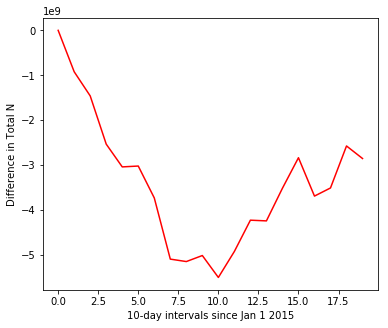

In [10]:
#plt.plot(SiGlobalTot[sdir0]-SiGlobalTot[sdir0][0],'r-')
#plt.plot(SiGlobalTot[sdir3]-SiGlobalTot[sdir3][0],'g-')
#plt.plot(40,test-SiGlobalTot[sdir1][0],'r*')
#plt.plot(40,test2-SiGlobalTot[sdir1][0],'k*')
fig,ax=plt.subplots(1,1,figsize=(6,5))
ax.plot(NGlobalTot[sdir1]-NGlobalTot[sdir1][0],'r-')
ax.set_xlabel('10-day intervals since Jan 1 2015')
ax.set_ylabel('Difference in Total N')

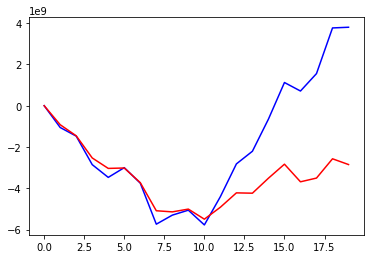

In [11]:
plt.plot(SiGlobalTot[sdir1]-SiGlobalTot[sdir1][0],'b-')
plt.plot(NGlobalTot[sdir1]-NGlobalTot[sdir1][0],'r-')
#plt.ylim((-5e9,0))

In [12]:
import pickle
pickle.dump(SiGlobalTot[sdir1],open(sdir1+'SiGlobalTot_'+tit+'.pkl','wb'))
pickle.dump(NGlobalTot[sdir1],open(sdir1+'NGlobalTot_'+tit+'.pkl','wb'))

In [13]:
tit

'spring16spun_Z7'